# Day 8 - Lab 1: Vision-Enabled UI/UX Agents

**Objective:** Use multi-modal vision models to generate a frontend UI from a design image, and then use a second agent to perform an automated design review.

**Estimated Time:** 90 minutes

**Introduction:**
Welcome to Day 8! Today, we'll explore one of the most exciting advancements in AI: vision. We will use a vision-capable model to act as a frontend developer, translating a design image directly into code. Then, we will create a second "UI/UX Critic" agent to automate the design review process, demonstrating a complete, AI-assisted frontend workflow.

For definitions of key terms used in this lab, please refer to the [GLOSSARY.md](../../GLOSSARY.md).

## Step 1: Setup

For this lab, we need to ensure we are using a vision-capable model. We will configure our `utils.py` helper to use a model like OpenAI's `gpt-4o` or Google's `gemini-2.5-pro`.

**Model Selection:**
This lab requires a vision-capable model. Excellent choices include `gpt-4o`, `gemini-2.5-pro`, or `deepseek-ai/DeepSeek-VL2`.

**Helper Functions Used:**
- `setup_llm_client()`: To configure the API client.
- `get_vision_completion()`: A specialized function to send an image and a text prompt to a vision model.
- `get_completion()`: To send text-only prompts for the refactoring step.
- `save_artifact()`: To save the generated code and the design review.

In [1]:
import sys
import os

# Add the project's root directory to the Python path
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
except IndexError:
    project_root = os.path.abspath(os.path.join(os.getcwd()))

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils import setup_llm_client, get_vision_completion, get_image_generation_completion, get_completion, save_artifact, clean_llm_output, recommended_models_table
from IPython.display import Image, display, Code

image_client, image_model_name, image_api_provider = setup_llm_client(model_name="gemini-2.5-flash-image-preview")
print(f"✅ Using {image_model_name} for image generation")

image_edit_client, image_edit_model_name, image_edit_api_provider = setup_llm_client(model_name="gemini-2.5-flash-image-preview")
print(f"✅ Using {image_edit_model_name} for image editing")

text_client, text_model_name, text_api_provider = setup_llm_client(model_name="gemini-2.5-flash")
print(f"✅ Using {text_model_name} for text generation")

# Ensure you select a vision-capable model
vision_client, vision_model_name, vision_api_provider = setup_llm_client(model_name="claude-sonnet-4-20250514")
print(f"✅ Using {vision_model_name} for vision tasks")


if not image_model_name or not vision_model_name:
    print("Could not set up a valid LLM client. Please check your .env file and utils.py configuration.")

2025-10-03 06:59:10,646 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash-image-preview latency_ms=None artifacts_path=None


✅ Using gemini-2.5-flash-image-preview for image generation


2025-10-03 06:59:11,941 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash-image-preview latency_ms=None artifacts_path=None


✅ Using gemini-2.5-flash-image-preview for image editing


2025-10-03 06:59:13,000 ag_aisoftdev.utils INFO LLM Client configured provider=google model=gemini-2.5-flash latency_ms=None artifacts_path=None


✅ Using gemini-2.5-flash for text generation


2025-10-03 06:59:14,270 ag_aisoftdev.utils INFO LLM Client configured provider=anthropic model=claude-sonnet-4-20250514 latency_ms=None artifacts_path=None


✅ Using claude-sonnet-4-20250514 for vision tasks


In [ ]:
from utils import recommended_models_table
recommended_models_table()

## Step 2: The Design Screenshot

This is the design we want our AI agent to build. It's a simple login form component. We will provide the URL to this image directly to the model.

Using gemini-2.5-flash-image-preview for image generation...
✅ Generated image saved to: C:\Users\labadmin\Desktop\Repository\AG-AISOFTDEV\artifacts\screens\image_1759490026.png



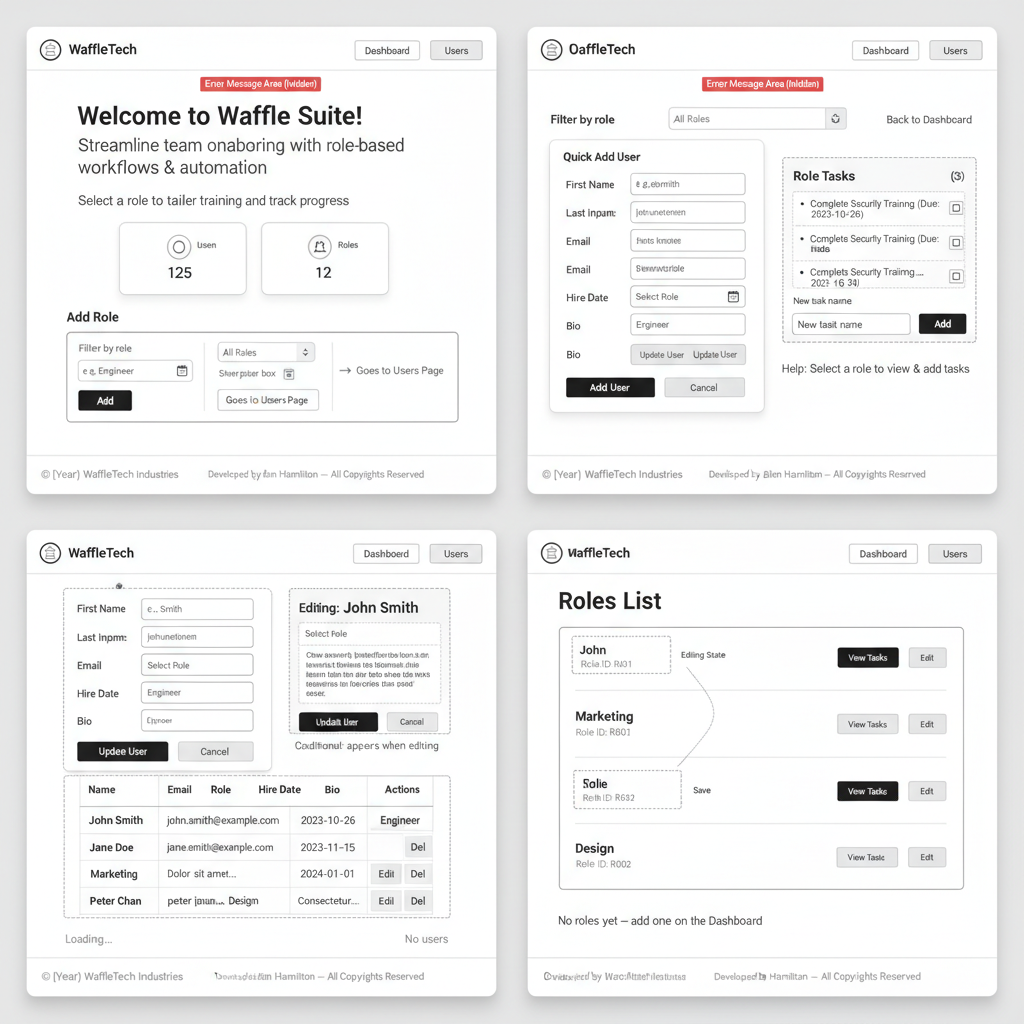

In [5]:
from utils.artifacts import load_artifact
from utils.llm import prompt_enhancer

prd = load_artifact("artifacts/day1_prd.md")
database_schema = load_artifact("artifacts/schema.sql")
api_spec = load_artifact("artifacts/app/main.py")

try:
    reference_site = load_artifact("artifacts/frontend_preview_1/waffle.html")
except Exception as e:
    print(f"Warning: {e}")
    reference_site = None


screen_generation_prompt = """Please create a comprehensive wireframe showing the complete UI layout and functionality of the WaffleTech customer onboarding system. The application has 3 main pages accessible via navigation.
HEADER (All Pages):

Left: "WaffleTech" logo/brand (clickable, returns to Dashboard)
Right: Navigation buttons for "Dashboard" and "Users"
Below header: Red error banner (when API errors occur)

PAGE 1: DASHBOARD
Layout from top to bottom:

Hero Section (centered):

Large heading: "Welcome to Waffle Suite!"
Subheading: "Streamline team onboarding with role-based workflows & automation."
Small text: "Select a role to tailor training and track progress."


Stat Cards (2 columns, centered):

Card 1: Icon + number of Users (clickable → goes to Users page)
Card 2: Icon + number of Roles (clickable → goes to Roles page)


Three-Column Grid:
Column 1 - Add Role:

Title: "Add Role"
Single-line form: Text input (placeholder: "e.g. Engineer") + "Add" button

Column 2 - Quick Add User:

Title: "Quick Add User" (or "Edit User" when editing)
Vertical form with fields:

First Name (text input)
Last Name (text input)
Email (email input)
Hire Date (date picker)
Role (dropdown select)
Bio (textarea, 2 rows)


Buttons: "Add User" (or "Update User" + "Cancel" when editing)

Column 3 - Role Tasks:

Title: "Role Tasks" with task count on right
Role dropdown: "Select Role" → "Choose a role"
Task list area (scrollable, max height, light background):

Shows bullet points with task descriptions, timeline dates, and "Edit" buttons
When editing: Shows input fields for description + timeline + Save/Cancel buttons
Empty state: "No tasks yet"


Bottom form: Text input "New task name" + "Add" button
Help text: "Select a role to view & add tasks." (when no role selected)



PAGE 2: USERS
Layout:

Filter Controls:

"Filter by role" dropdown (includes "All Roles" option)
"Reset" link


Edit Form (conditional, appears when editing):

Title: "Editing: [User Name]"
Same form as Dashboard Quick Add User section


Users Table:

Columns: Name | Email | Role | Hire Date | Bio | Actions
Each row has "Edit" and "Del" buttons
Empty state: "No users"
Loading state: "Loading..."



PAGE 3: ROLES
Layout:

Header Row:

Left: "Roles" title
Right: "Back to Dashboard" link


Roles List (bordered, white background):

Each role as a row with:

Left: Role name (becomes editable input when editing) + Role ID below in gray
Right: Two buttons:

Normal state: "View Tasks" + "Edit"
Edit state: "Save" + "Cancel"




Empty state: "No roles yet — add one on the Dashboard."



FOOTER (All Pages):

Copyright notice: "© [Year] WaffleTech Industries"
Small text: "Developed by Booz Allen Hamilton — All Copyrights Reserved"

DESIGN NOTES:

White cards/sections with shadows and rounded corners
Black buttons with white text
Gray text hierarchy (darker for primary, lighter for secondary)
Border-based separations
Responsive: 3-column grid stacks to single column on mobile
Loading states show "..." text
Error messages in red banner at top

Do not display any error messages
Please create a clear, labeled wireframe showing these three page states with proper spacing, hierarchy, and component relationships."""



print(f"Using {image_model_name} for image generation...")
file_path, image_url = get_image_generation_completion(screen_generation_prompt, image_client, image_model_name, image_api_provider)

# Display the generated image if successful
if file_path and image_url:
    print(f"✅ Generated image saved to: {file_path}")
    display(Image(url=image_url))
elif image_url:
    print(f"❌ Image generation failed: {image_url}")
else:
    print("❌ Image generation returned no result")

In [ ]:
recommended_models_table()

In [ ]:
#login_form_url = "https://i.imgur.com/s42SYz6.png"
display(Image(url="C:\\Users\\labadmin\\Desktop\\Repository\\AG-AISOFTDEV\\artifacts\\screens\\image_1759251581.png"))

## Step 3: The Challenges

### Challenge 1 (Foundational): Generating a Monolithic UI Component

**Task:** Use the vision model to generate a single, self-contained React component that replicates the design from the image.

> **Tip for Vision Prompts:** Be specific about the output format. Telling the model you want 'React' and 'Tailwind CSS' is crucial. The more specific your technical constraints, the better the generated code will be.

**Instructions:**
1.  Create a prompt that asks the vision model to act as an expert frontend developer.
2.  The prompt should instruct the model to analyze the image at the provided URL.
3.  Ask it to generate a single React component using Tailwind CSS for styling.
4.  The output should be a single block of JSX code.

**Expected Quality:** A single file's worth of React code that, when rendered, visually approximates the login form in the screenshot.

In [ ]:
# Explain the specified image using the vision-capable LLM
image_path = r"C:\Users\labadmin\Desktop\Repository\AG-AISOFTDEV\artifacts\screens\image_1759283574.png"
corrected_path = r"C:\Users\labadmin\Desktop\Repository\AG-AISOFTDEV\artifacts\screens\corrected_employee_onboarding_interface.png"

edit_image_prompt = f"""

## Required Components

### 1. Header Section
- Title: "Employee Onboarding System"
- Subtitle: "Manage employee records efficiently"

### 2. Add New Employee Form
Include these labeled fields in clear English:
- **First Name** (text input with placeholder "Enter first name")
- **Last Name** (text input with placeholder "Enter last name")
- **Email** (email input with placeholder "employee@company.com")
- **Role** (text input with placeholder "e.g., Software Engineer")
- **Department** (dropdown or text input with placeholder "e.g., Engineering")
- **User ID** (text input with placeholder "Enter user ID")
- **Date Joined** (date picker with format MM/DD/YYYY)

Action buttons:
- "Add Employee" (primary button in blue/teal)
- "Clear Form" (secondary button)

### 3. Employee List/Table
Table with columns:
- First Name | Last Name | Email | Role | Department | User ID | Date Joined | Actions

Actions column should have:
- "Edit" button
- "Delete" button

### 4. Edit Employee Modal/Form
Same fields as Add form, but with:
- "Update Employee" button
- "Cancel" button

## Technical Requirements
- Use HTML5, CSS3, and vanilla JavaScript (or React if preferred)
- Use a clean sans-serif font like Arial, Roboto, or Open Sans
- Modern teal/blue color scheme (#17a2b8 or similar)
- NO special characters, NO non-English text
- All text must be in standard ASCII English characters only
- Include basic form validation with English error messages

## Testing Checklist
Before showing the result, verify:
✓ Every label is in English
✓ Every button text is in English
✓ Every placeholder is in English
✓ No garbled characters anywhere
✓ Font renders clearly and consistently

Please create this as a single HTML file with embedded CSS and JavaScript that I can immediately use.

Context: {image_path}
"""


print(f"Using {image_edit_model_name} for image editing...")
file_path, image_url = get_image_generation_completion(
    edit_image_prompt,
    image_edit_client,
    image_edit_model_name,
    image_edit_api_provider
)

# Display the generated image if successful
if file_path and image_url:
    print(f"✅ Generated image saved to: {file_path}")
    display(Image(url=image_url))
    save_artifact(file_path, image_url, "artifacts/screens/corrected_employee_onboarding_interface.png", overwrite=True)
elif image_url:
    print(f"❌ Image generation failed: {image_url}")
else:
    print("❌ Image generation returned no result")

In [ ]:
# Explain the specified image using the vision-capable LLM
image_path = r"C:\Users\labadmin\Desktop\Repository\AG-AISOFTDEV\artifacts\screens\image_1759283702.png"

explain_image_prompt = f"""
You are an expert frontend developer specializing in React and Tailwind CSS. 

Analyze the employee onboarding interface shown in {image_path} and generate a single, self-contained React component that accurately replicates its design and functionality.

**Requirements:**

1. **Technology Stack:**
   - Use React (functional component with hooks)
   - Use Tailwind CSS for ALL styling (no custom CSS files)
   - Include all necessary imports

2. **Component Structure:**
   - Create a single, complete React component
   - Implement full CRUD functionality (Create, Read, Update, Delete)
   - Use React useState for state management
   - Include form validation

3. **Features to Implement:**
   - Form to add new employees with fields: First Name, Last Name, Email, Role, Department, User ID, Date Joined
   - Employee list/table displaying all records
   - Edit functionality (inline or modal)
   - Delete functionality with confirmation
   - Clear visual feedback for actions (success/error messages)

4. **Design Requirements:**
   - Match the color scheme from the image (teal/blue tones)
   - Replicate the layout structure (sidebars, panels, spacing)
   - Use clean typography with proper hierarchy
   - Ensure responsive design
   - Include hover states and transitions
   - Add appropriate icons (you can use emoji or describe where icons should go)

5. **Code Quality:**
   - Write clean, well-organized code
   - Include comments for major sections
   - Use semantic HTML elements
   - Ensure accessibility (labels, ARIA attributes where needed)

6. **Output Format:**
   - Provide a SINGLE, complete, copy-paste-ready React component
   - The code should be immediately usable without additional files
   - Include sample initial data (2-3 employee records)

**Output as a single JSX code block that I can directly use in my React application.**
"""

print("--- Requesting image explanation from vision model ---")
if vision_model_name:
    explanation = get_vision_completion(explain_image_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    cleaned_explanation = clean_llm_output(explanation, language="markdown")
    display(Code(cleaned_explanation, language="markdown"))
    # Save the explanation for later reference
    save_artifact(cleaned_explanation, "artifacts/image_explanation.md",overwrite=True)
else:
    print("Skipping image explanation because no vision model is configured.")

In [ ]:
# TODO: Write a prompt to generate a single React component from the image.
generate_ui_prompt = f"""
"
You are an expert frontend developer specializing in React and Tailwind CSS.

Analyze the employee onboarding interface shown in {image_path} and generate a single, self-contained React component that precisely replicates this design.

**Visual Analysis from Image:**
The interface shows:
- Dark blue/slate header and footer bars
- Light gray background
- Main heading "Employee Omabarading System" with cyan subtitle "Manage employee records efficiently"
- Cyan-bordered form section titled "Add New Employee"
- Form fields: First Name, Email, Role, Department, Date Joined
- Two buttons: "Add Employee" (cyan) and "Clear Form" (gray)
- Employee List table below with columns: First Name, Last Name, Email, Role, Department, User ID, Date Joined, Actions
- Edit modal overlay showing "Edit Employee" form
- Action buttons include cyan "Edit" and red "Delete" buttons
- Modal has "Update Employee", "Edit", "Edit", and "Cancel" buttons

**Technical Requirements:**
- Framework: React (functional component with hooks)
- Styling: Tailwind CSS exclusively
- State Management: React useState for employees, form data, edit mode, and modal visibility
- Output: Single, copy-paste-ready JSX component

**Exact Features to Implement:**

1. **Header Section:**
   - Dark slate background (bg-slate-700 or similar)
   - Centered layout with padding

2. **Main Content:**
   - Light gray background (bg-gray-100)
   - Centered container with max-width
   - Title: "Employee Omabarading System" (dark slate text, large font)
   - Subtitle: "Manage employee records efficiently" (cyan text)

3. **Add New Employee Form:**
   - Cyan border (border-cyan-500, 3px width)
   - White background with padding
   - Rounded corners
   - Form fields with labels aligned left:
     * First Name (text input)
     * Email (email input with placeholder "employee@company.com")
     * Role (text input with placeholder "e.g, Software Engineer")
     * Department (text input with placeholder "Enter user ID")
     * Date Joined (date input with placeholder "MM/DD/YYYY")
   - Buttons:
     * "Add Employee" - cyan background (bg-cyan-500), white text
     * "Clear Form" - gray background, darker text

4. **Employee List Table:**
   - White background
   - Table headers with light gray background
   - Columns: First Name | Last Name | Email | Role | Department | User ID | Date Joined | Actions
   - Sample data rows visible
   - Actions column with:
     * "Edit" button (cyan, small)
     * "Delete" button (red, small)

5. **Edit Employee Modal:**
   - Overlay with semi-transparent dark background
   - White modal card centered on screen
   - Close X button in top right
   - Title: "Edit Employee"
   - Form fields (same as Add form) but including Last Name
   - Pre-filled with employee data
   - Buttons at bottom:
     * "Update Employee" (cyan)
     * "Edit" button (cyan) - appears twice in image
     * "Cancel" (gray)

6. **Delete Confirmation:**
   - Simple browser confirm dialog or custom modal
   - Confirm before deleting employee

**Functional Requirements:**
- Add new employee with form validation
- Display all employees in table
- Edit employee (opens modal with pre-filled data)
- Update employee information
- Delete employee with confirmation
- Clear form functionality
- Form validation (required fields, email format)
- Success/error messages (optional toast or inline messages)

**Color Palette (extract from image):**
- Primary: Cyan/Turquoise (#06b6d4 or bg-cyan-500)
- Background: Light Gray (#f3f4f6 or bg-gray-100)
- Dark sections: Slate (#334155 or bg-slate-700)
- Text: Dark slate for headings, gray for body
- Danger: Red (#ef4444 or bg-red-500)
- Borders: Cyan for primary, light gray for table

**Code Structure:**
- Component name: EmployeeOnboardingSystem
- Use useState for: employees array, formData object, editingEmployee, showModal
- Include 3-4 sample employees in initial state
- Proper event handlers for add, edit, update, delete, cancel
- Form reset after successful operations

**Deliverable:**
Provide a complete, production-ready React component with Tailwind CSS that matches the image exactly. The code should be in a single code block, fully self-contained, and immediately usable. Include all functionality shown in the interface.
"""


print("--- Generating Monolithic UI Component ---")
if vision_model_name:
    generated_monolithic_code = get_vision_completion(generate_ui_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    cleaned_code = clean_llm_output(generated_monolithic_code, language='jsx')
    save_artifact(cleaned_code, "artifacts/monolithic_ui_component.jsx", overwrite=True)
    display(Code(cleaned_code, language='jsx'))
else:
    print("Skipping UI generation because no valid model is configured.")
    cleaned_code = ""

### Challenge 2 (Intermediate): Refactoring into Reusable Components

**Task:** A single, large component is not good practice. Now, prompt the LLM to refactor the monolithic code it just generated into smaller, reusable sub-components.

**Instructions:**
1.  Create a new prompt.
2.  Provide the monolithic JSX code from the previous step as context.
3.  Instruct the LLM to act as a senior frontend developer who champions clean code.
4.  Ask it to refactor the code by creating smaller, reusable components (e.g., `<StyledButton>`, `<InputWithIcon>`).
5.  The final output should be the complete code with the new, smaller components defined and used within the main `Login` component.

**Expected Quality:** A well-structured React file that demonstrates the component-based architecture, which is a fundamental best practice in modern frontend development.

In [ ]:
# TODO: Write a prompt to refactor the monolithic code into smaller components.
refactor_ui_prompt = f"""
# # Frontend Code Refactoring Prompt

You are a senior frontend developer who champions clean code principles, component reusability, and maintainable architecture. Your task is to refactor the monolithic JSX code provided below into a well-structured, component-based architecture.

## Context Code

{generated_monolithic_code}

## Refactoring Requirements

1. **Analyze the existing code** and identify repeated patterns, UI elements, and logical groupings
2. **Extract reusable components** such as:
   - `<StyledButton>` - for button variations
   - `<InputWithIcon>` - for input fields with icons
   - `<Card>` - for card-based layouts
   - `<FormField>` - for form input groups with labels
   - Any other patterns you identify

3. **Apply best practices**:
   - Use meaningful component names that describe their purpose
   - Keep components focused and single-responsibility
   - Extract inline styles into component-level styling
   - Use props effectively for component customization
   - Add prop validation where appropriate
   - Remove any ```~```, `~~`, or other non-standard characters

4. **Maintain functionality**: Ensure all interactive features, state management, and business logic remain intact

## Deliverable

Provide the **complete refactored code** with:
- All new reusable components defined at the top or in logical sections
- The main component using these smaller components
- Clear component hierarchy
- Comments explaining the purpose of each major component
- The code should be production-ready and immediately usable

The final output should be cleaner, more maintainable, and follow React best practices while preserving all original functionality.
"""

print("--- Refactoring UI into Components ---")

if cleaned_code:
    refactored_code = get_completion(refactor_ui_prompt, vision_client, vision_model_name, vision_api_provider)
    cleaned_refactored_code = clean_llm_output(refactored_code, language='jsx')
    display(Code(cleaned_refactored_code, language='jsx'))
    save_artifact(cleaned_refactored_code, "artifacts/refactored_ui_components.jsx", overwrite=True)
else:
    print("Skipping refactoring because monolithic code was not generated.")
    cleaned_refactored_code = ""

### Challenge 3 (Advanced): The AI UI/UX Critic Agent

**Task:** Create a new "UI/UX Critic" agent. This agent will be given both the original design image and the generated code, and its job is to perform an automated design review.

**Instructions:**
1.  Create a final, complex prompt for a new agent.
2.  The prompt should instruct the agent to act as a meticulous UI/UX designer.
3.  Provide the agent with two pieces of context: the URL of the original design image and the final, refactored React code.
4.  The agent's task is to compare the code's likely rendered output to the design image and list any visual inconsistencies in spacing, font size, color, or layout.

**Expected Quality:** A critical design review in markdown format. This demonstrates a powerful AI-on-AI workflow, where one AI generates work and another AI validates it, automating a time-consuming QA step.

In [ ]:
# TODO: Write a prompt for the UI/UX Critic agent.
critic_agent_prompt = f"""
You are a meticulous UI/UX designer and design QA specialist with years of experience in design systems, visual hierarchy, and pixel-perfect implementation. Your role is to perform a comprehensive design review by comparing the original design specification with the implemented code.

**Your Mission:**
Analyze the provided design image and React component code, then identify any visual inconsistencies, deviations, or improvements needed to achieve pixel-perfect implementation.

**Context Provided:**
1. **Original Design Image:** {image_path}
2. **Implemented React Code:** {cleaned_refactored_code}

**Review Criteria:**

Evaluate the implementation across these dimensions:

### 1. **Layout & Spacing**
- Component positioning and alignment
- Padding and margins (inner and outer spacing)
- Grid/flex layout accuracy
- Whitespace distribution
- Container widths and max-widths
- Responsive behavior

### 2. **Typography**
- Font families and fallbacks
- Font sizes (headings, body text, labels, buttons)
- Font weights (light, regular, medium, bold)
- Line heights and letter spacing
- Text alignment
- Text colors and contrast ratios

### 3. **Colors**
- Primary color values (exact hex/rgb codes)
- Secondary and accent colors
- Background colors
- Border colors
- Text colors (headings, body, muted text)
- Button colors (normal, hover, active states)
- Color consistency across components

### 4. **Components & Elements**

**Buttons:**
- Size (height, padding)
- Border radius
- Font size and weight
- Color variants (primary, secondary, danger)
- Hover and active states
- Icon placement (if any)

**Form Inputs:**
- Input height and padding
- Border style, width, and color
- Border radius
- Placeholder text styling
- Focus states
- Label positioning and styling
- Error state styling

**Table:**
- Header styling (background, text, borders)
- Row height and padding
- Column widths and alignment
- Alternating row colors (if any)
- Border styles
- Action button styling and spacing

**Modal/Dialog:**
- Overlay opacity and color
- Modal width and positioning
- Border radius
- Shadow/elevation
- Close button styling and position
- Header and content spacing

### 5. **Visual Hierarchy**
- Emphasis on primary actions
- Visual weight distribution
- Focus indicators
- Disabled states
- Error/success messaging

### 6. **Accessibility Concerns**
- Color contrast ratios (WCAG compliance)
- Focus visible states
- Interactive element sizing (touch targets)
- Label associations

**Output Format:**

Provide your review in the following structured markdown format:

---

# UI/UX Design Review: Employee Onboarding System

## Executive Summary
[Brief 2-3 sentence overview of implementation quality]

**Overall Score:** [X/10]
**Critical Issues:** [number]
**Minor Issues:** [number]
**Recommendations:** [number]

---

## ✅ What's Working Well
- [List aspects that match the design accurately]
- [Highlight good practices or improvements]

---

## 🔴 Critical Issues (Must Fix)

### Issue #1: [Title]
- **Location:** [Which component/section]
- **Design Spec:** [What the design shows]
- **Current Implementation:** [What the code produces]
- **Impact:** [How this affects user experience]
- **Fix Required:** [Specific code changes needed]

[Repeat for each critical issue]

---

## 🟡 Minor Issues (Should Fix)

### Issue #1: [Title]
- **Location:** [Component/section]
- **Observation:** [What's slightly off]
- **Suggested Fix:** [Recommended adjustment]

[Repeat for each minor issue]

---

## 💡 Recommendations (Nice to Have)

1. **[Recommendation title]**
   - Why: [Reasoning]
   - How: [Implementation suggestion]

[Additional recommendations]

---

## 📏 Detailed Measurements

### Spacing Audit
| Element | Design Value | Code Value | Status |
|---------|--------------|------------|--------|
| Header padding | [X]px | [Y]px | ✅ / ❌ |
| Form field gaps | [X]px | [Y]px | ✅ / ❌ |
| Button padding | [X]px | [Y]px | ✅ / ❌ |

### Color Audit
| Element | Design Color | Code Color | Status |
|---------|--------------|------------|--------|
| Primary button | #06b6d4 | [actual] | ✅ / ❌ |
| Background | #f3f4f6 | [actual] | ✅ / ❌ |

### Typography Audit
| Element | Design | Code | Status |
|---------|--------|------|--------|
| Main heading | [specs] | [actual] | ✅ / ❌ |
| Body text | [specs] | [actual] | ✅ / ❌ |

---

## 🎯 Priority Action Items

**High Priority (Fix Immediately):**
1. [Action item with specific guidance]
2. [Action item with specific guidance]

**Medium Priority (Fix Soon):**
1. [Action item]
2. [Action item]

**Low Priority (Nice to Have):**
1. [Action item]

---

## 📝 Code Suggestions
```javascript
// Example: Current problematic code
<button className="bg-blue-500"> // ❌

// Suggested fix to match design
<button className="bg-cyan-500"> // ✅


"""

print("--- Invoking UI/UX Critic Agent ---")
if cleaned_refactored_code:
    design_review = get_vision_completion(critic_agent_prompt, image_path, vision_client, vision_model_name, vision_api_provider)
    display(Code(design_review, language='markdown'))
    save_artifact(design_review, "artifacts/design_review.md", overwrite=True)
else:
    print("Skipping critic agent because refactored code is not available.")

In [ ]:
# TODO: Write a prompt to refactor the monolithic code into smaller components.
incorporate_feedback_prompt = f"""
# # You are a senior frontend developer tasked with implementing critical design fixes based on a comprehensive UI/UX design review.

**Context:**
You previously created a refactored Employee Onboarding System component {refactored_code}. 
A design review has identified several critical issues that must be addressed to match the original design specification.{design_review}

**Your Task:**
Update the refactored React component code to fix all CRITICAL issues identified in the design review. Focus on achieving pixel-perfect implementation that matches the original design.

**Design Review Document:**
[Paste the design_review.md content here, or specifically the Critical Issues section]

**Critical Issues to Fix (Priority Order):**

### 1. Form Layout Structure Mismatch
**Problem:** Form fields are in a responsive grid (md:grid-cols-2 lg:grid-cols-5) but the design shows a single horizontal row with 5 columns.

**Required Fix:**
- Change the AddEmployeeSection form layout from responsive grid to fixed horizontal layout
- Use flexbox with flex-wrap to maintain 5 fields in a single row
- Each field should have minimum width of 180px
- Maintain 16px gap between fields
- Provide a deployable code without any ``~`` or `~~` characters.


"""

print("--- Refactoring UI into Components ---")

if cleaned_code:
    updated_code = get_completion(incorporate_feedback_prompt, vision_client, vision_model_name, vision_api_provider)
    cleaned_updated_code = clean_llm_output(updated_code, language='jsx')
    display(Code(cleaned_updated_code, language='jsx'))
    save_artifact(cleaned_updated_code, "artifacts/updated_ui_components.jsx", overwrite=True)
else:
    print("Skipping refactoring because monolithic code was not generated.")
    cleaned_updated_code = ""

## Lab Conclusion

Fantastic! You have completed a full, end-to-end frontend development workflow using multiple AI agents. You used a vision-powered agent to generate code from a design, a refactoring agent to improve the code's structure, and a critic agent to perform an automated design review. This powerful combination of skills can dramatically accelerate the process of turning visual ideas into functional user interfaces.

> **Key Takeaway:** The workflow of **Generate -> Refactor -> Critique** is a powerful AI-assisted development pattern. Using specialized agents for each step allows you to rapidly create a first draft, improve its quality, and then automatically check it for correctness, significantly speeding up the iteration cycle.